<a href="https://colab.research.google.com/github/PratikStar/google-colab/blob/main/1_Create_Audio_Spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#samples in the loaded signal: 16317
Length of stft: 256
Length of stft[0]: 64
Length of norm_array: 256
Length of norm_array[0]: 64
Processed file 00001-01 01A US Double Nrm.wav
#samples in the loaded signal: 16317
Length of stft: 256
Length of stft[0]: 64
Length of norm_array: 256
Length of norm_array[0]: 64
Processed file 00002-01 01B Essex A30.wav
#samples in the loaded signal: 16317
Length of stft: 256
Length of stft[0]: 64
Length of norm_array: 256
Length of norm_array[0]: 64
Processed file 00003-01 01C Brit Plexi Jump.wav
#samples in the loaded signal: 16317
Length of stft: 256
Length of stft[0]: 64
Length of norm_array: 256
Length of norm_array[0]: 64
Processed file 00004-01 01D Cali Rectifire.wav
#samples in the loaded signal: 16317
Length of stft: 256
Length of stft[0]: 64
Length of norm_array: 256
Length of norm_array[0]: 64
Processed file 00005-01 02A US Deluxe Nrm.wav
#samples in the loaded signal: 16317
Length of stft: 256
Length of stft[0]: 64
Length of norm_array: 256
L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Processed file 00021-01 06A Cali Texas Ch 1.wav
#samples in the loaded signal: 16317
Length of stft: 256
Length of stft[0]: 64
Length of norm_array: 256
Length of norm_array[0]: 64
Processed file 00022-01 06B Essex A15.wav
#samples in the loaded signal: 16317
Length of stft: 256
Length of stft[0]: 64
Length of norm_array: 256
Length of norm_array[0]: 64
Processed file 00023-01 06C Derailed Ingrid.wav
#samples in the loaded signal: 16317
Length of stft: 256
Length of stft[0]: 64
Length of norm_array: 256
Length of norm_array[0]: 64
Processed file 00024-01 06D German Mahadeva.wav
#samples in the loaded signal: 16317
Length of stft: 256
Length of stft[0]: 64
Length of norm_array: 256
Length of norm_array[0]: 64
Processed file 00025-01 07A WhoWatt 100.wav
#samples in the loaded signal: 16317
Length of stft: 256
Length of stft[0]: 64
Length of norm_array: 256
Length of norm_array[0]: 64
Processed file 00026-01 07B Line 6 Litigator.wav
#samples in the loaded signal: 16317
Length of stft: 256

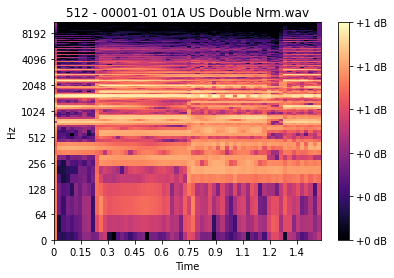

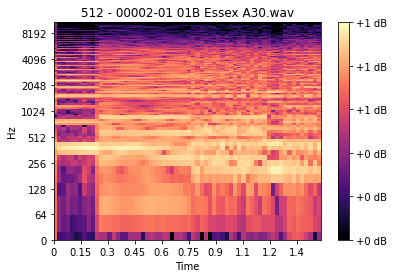

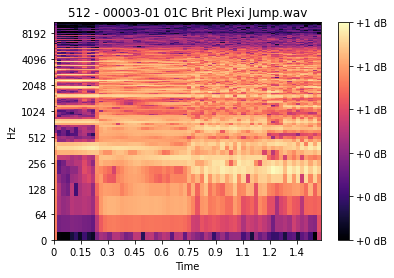

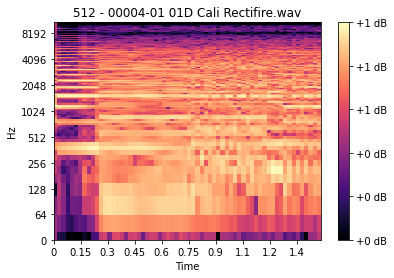

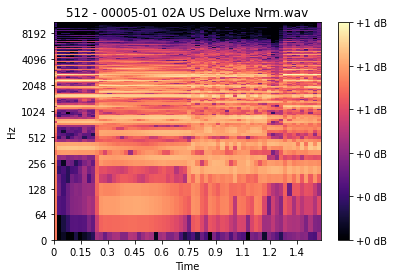

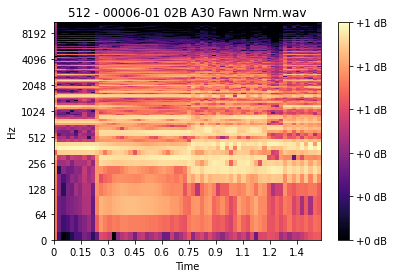

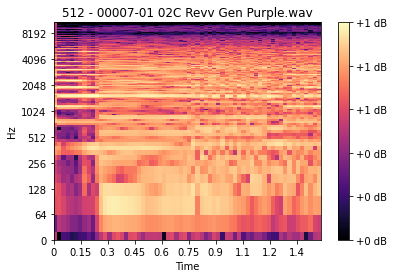

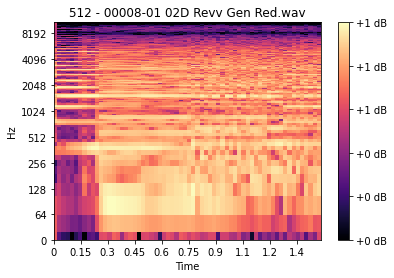

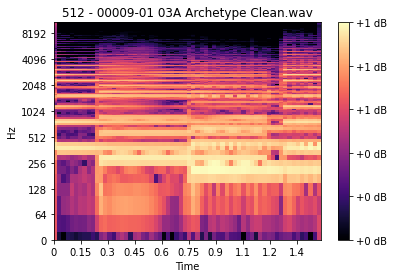

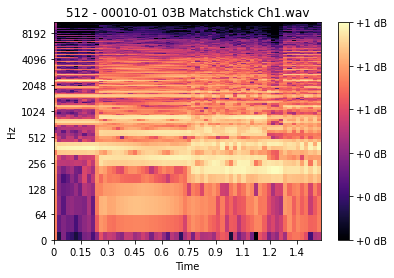

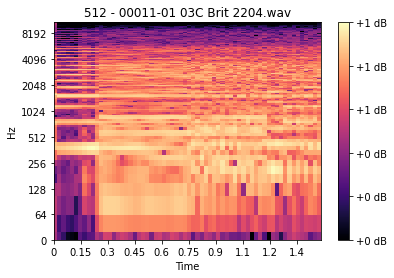

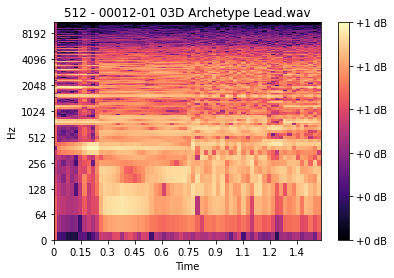

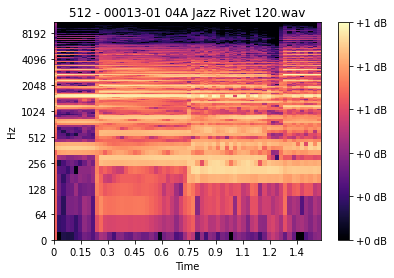

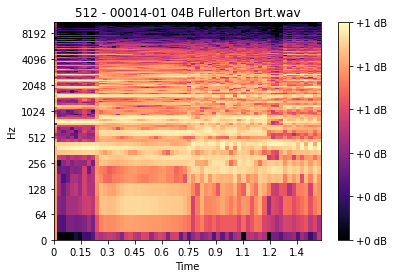

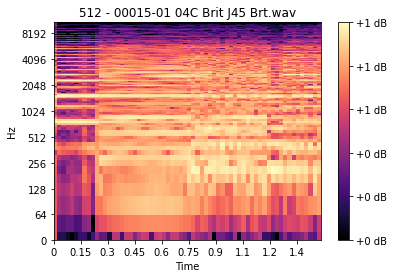

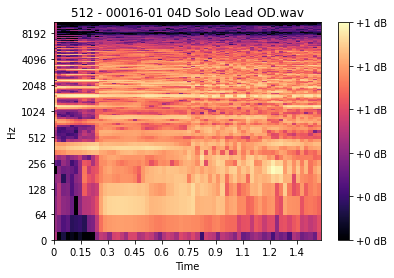

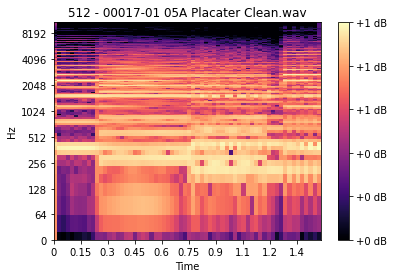

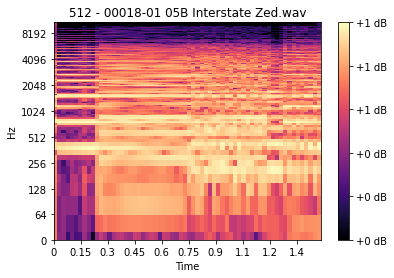

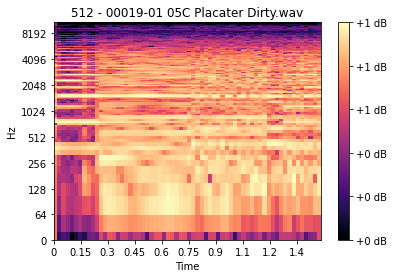

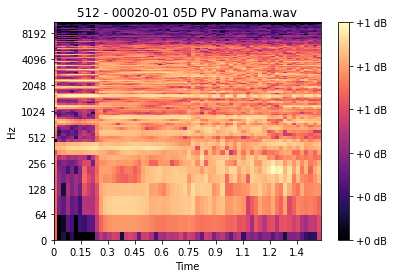

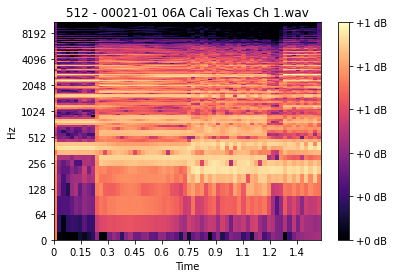

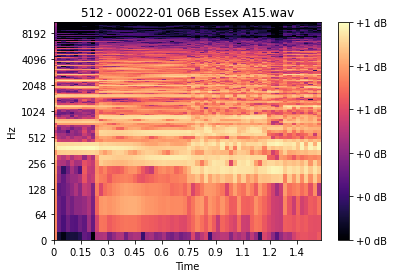

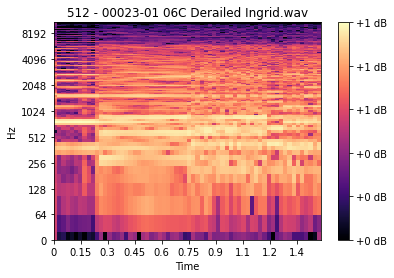

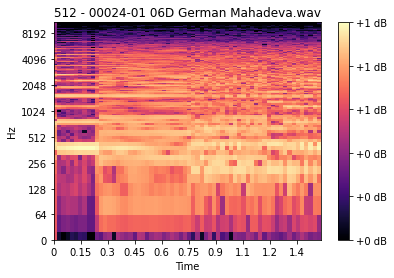

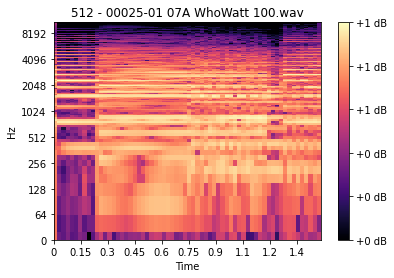

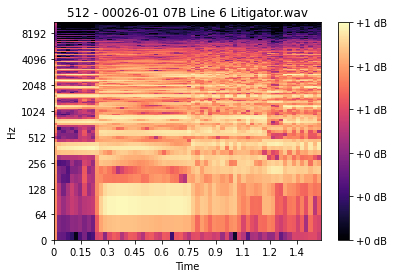

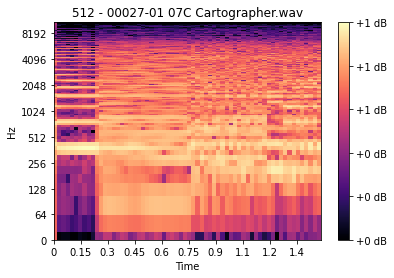

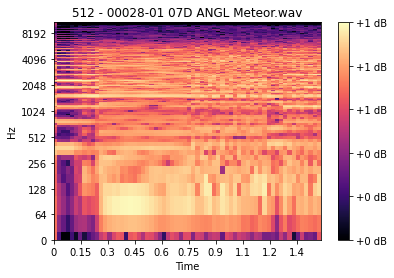

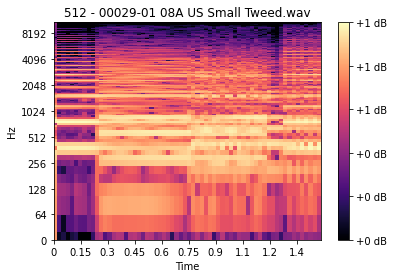

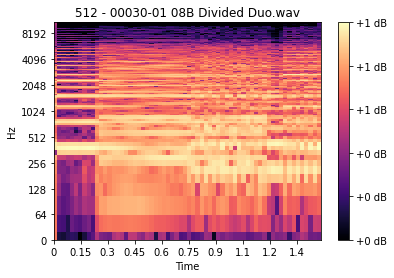

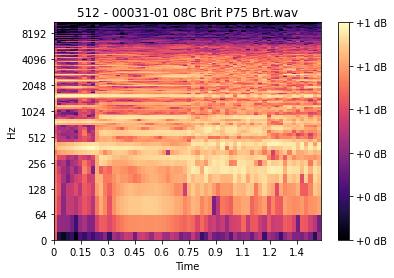

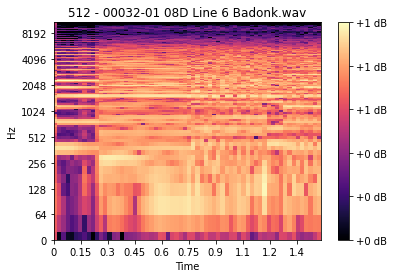

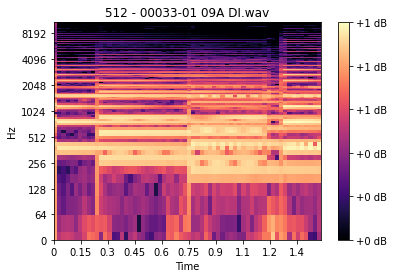

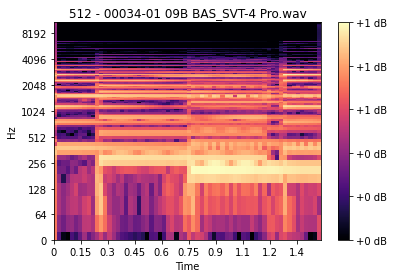

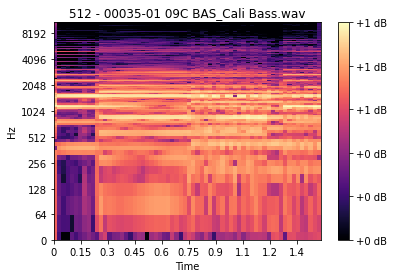

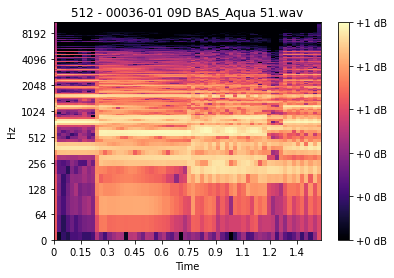

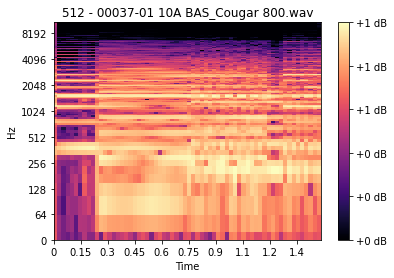

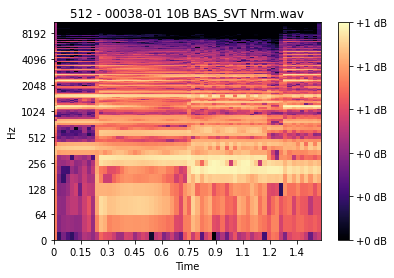

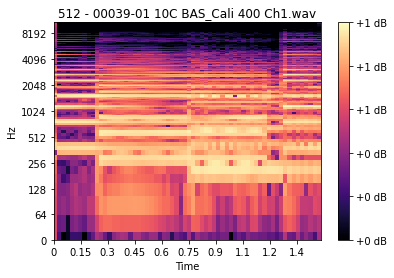

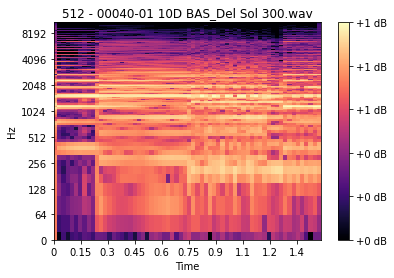

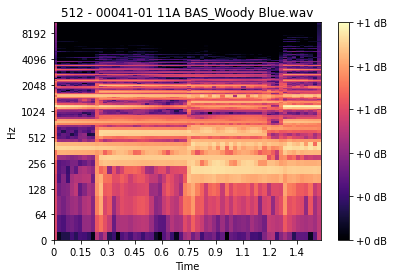

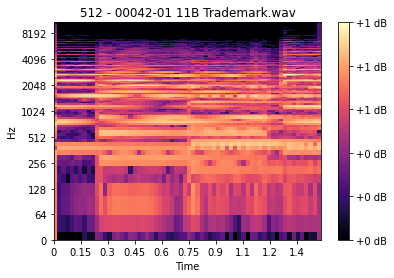

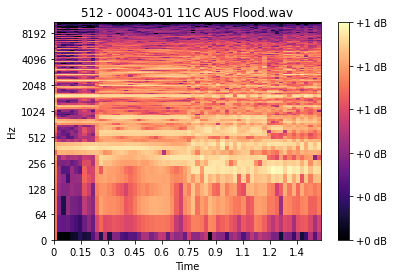

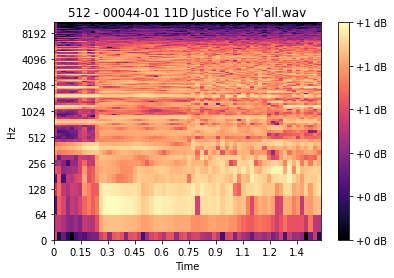

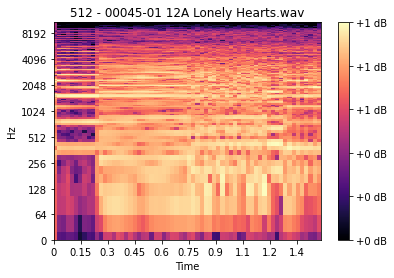

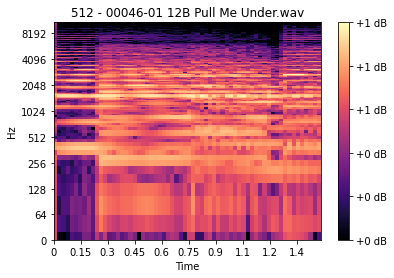

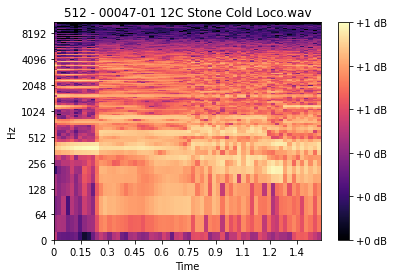

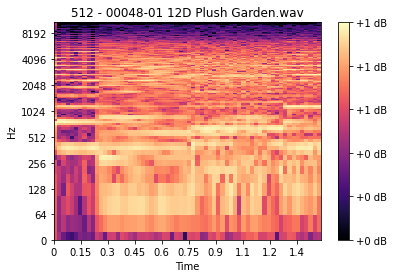

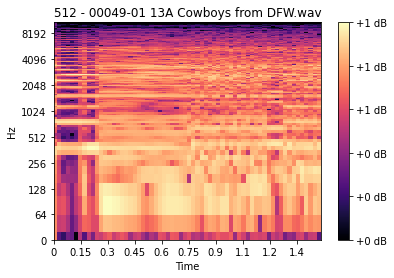

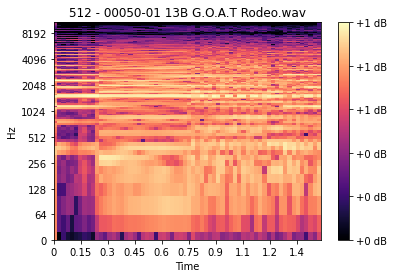

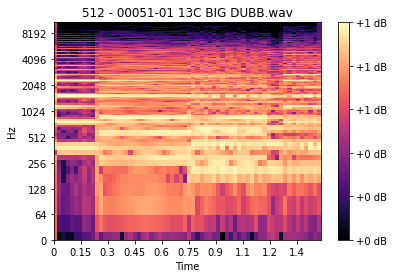

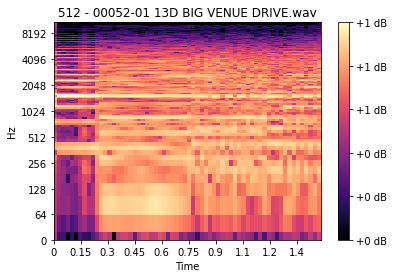

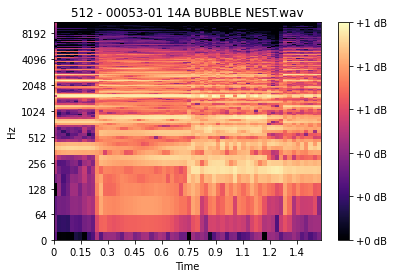

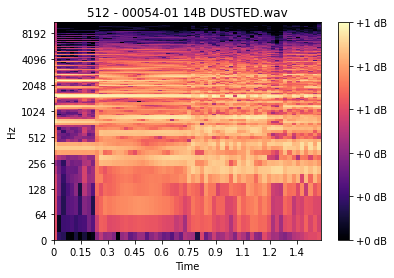

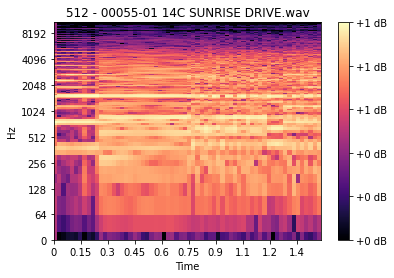

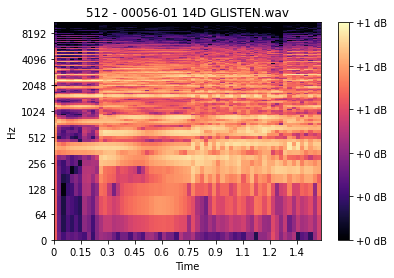

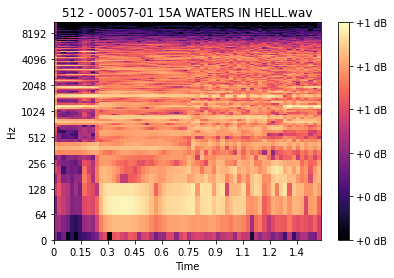

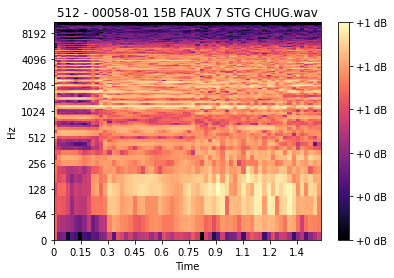

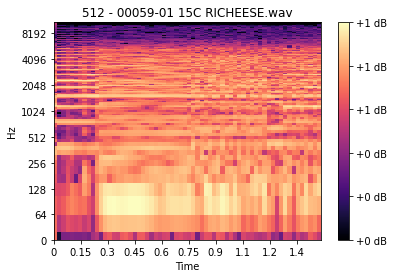

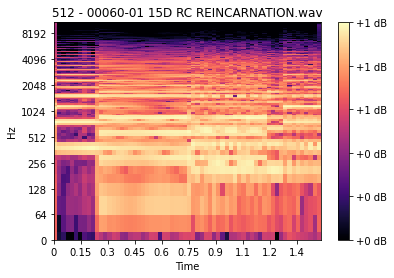

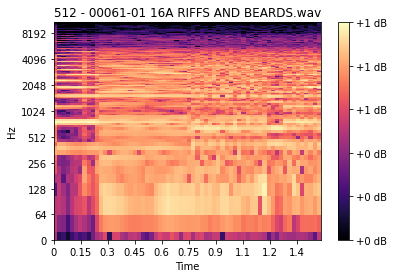

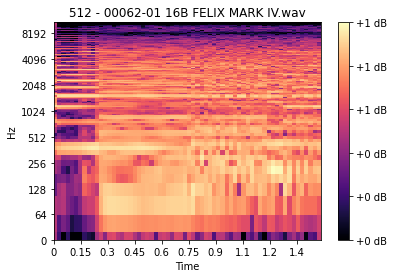

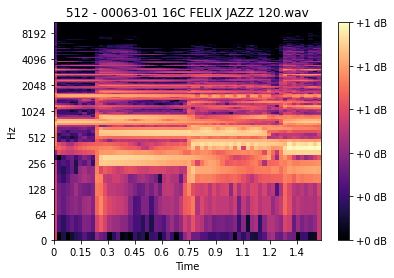

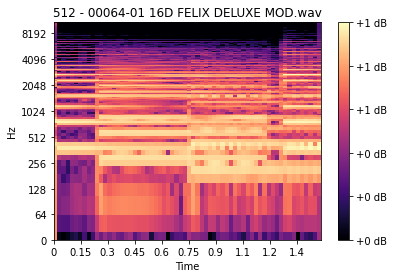

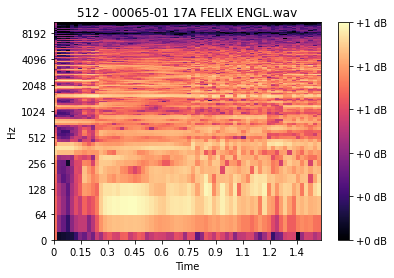

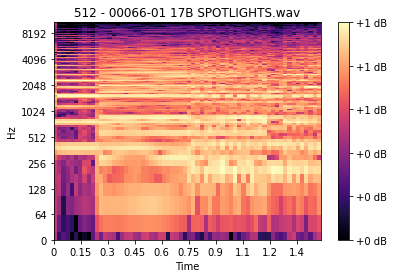

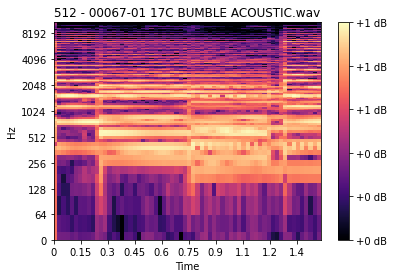

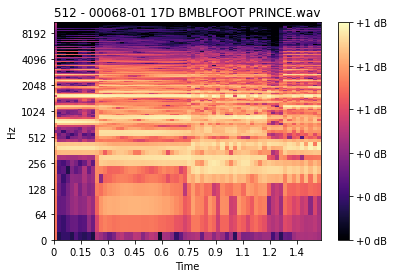

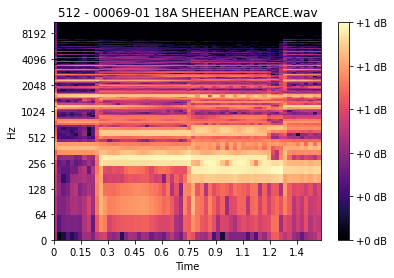

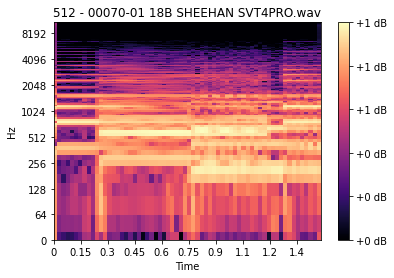

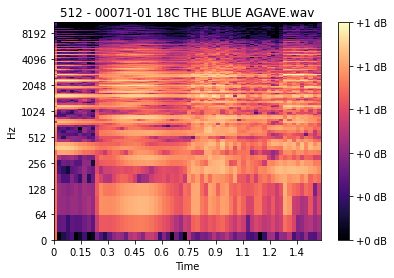

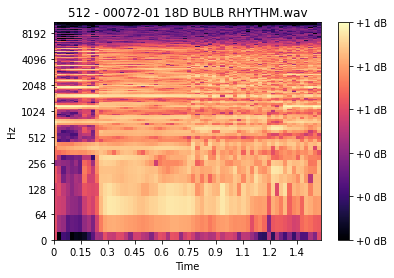

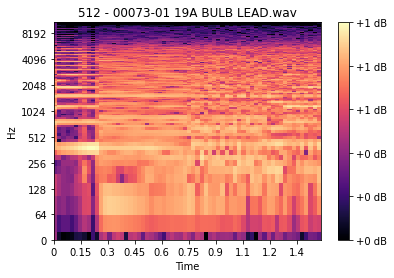

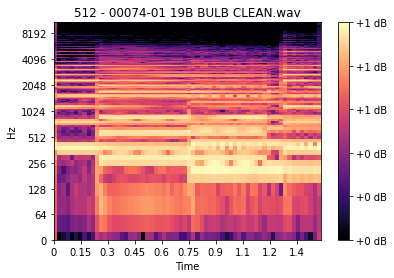

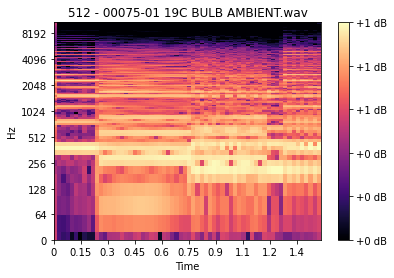

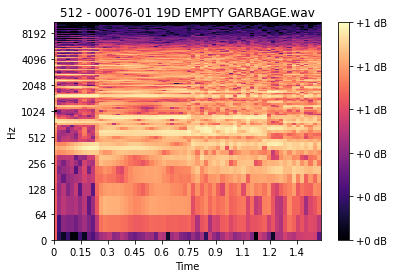

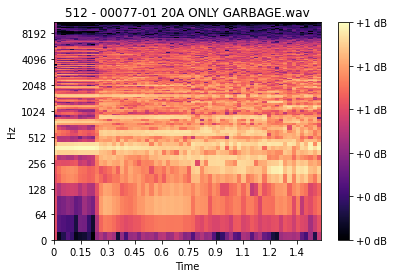

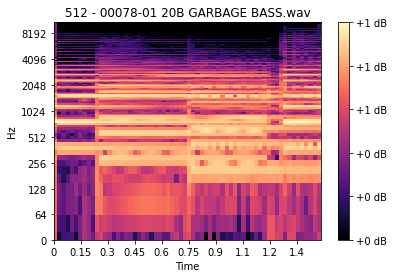

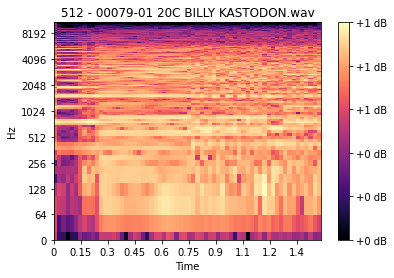

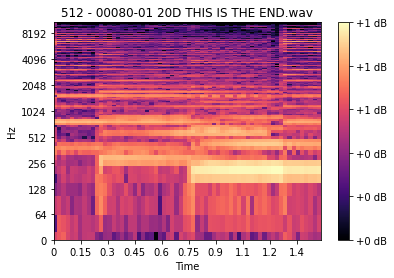

In [ ]:
"""
1- load a file
2- pad the signal (if necessary)
3- extracting log spectrogram from signal
4- normalise spectrogram
5- save the normalised spectrogram

PreprocessingPipeline
"""
import os
import pickle
import re
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


class Loader:
    """Loader is responsible for loading an audio file."""

    def __init__(self, sample_rate, offset, duration, mono):
        self.sample_rate = sample_rate
        self.duration = duration
        self.offset = offset
        self.mono = mono

    def load(self, file_path):
        signal = librosa.load(file_path,
                              sr=self.sample_rate,
                              duration=self.duration,
                              offset=self.offset,
                              mono=self.mono)[0]
        print("#samples in the loaded signal: " + str(len(signal)))
        # print(np.mean(signal))
        # print(np.amin(signal))
        # print(np.amax(signal))
        # print("Raw signal: " + str(signal))
        return signal


class Padder:
    """Padder is responsible to apply padding to an array."""

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array


class LogSpectrogramExtractor:
    """LogSpectrogramExtractor extracts log spectrograms (in dB) from a
    time-series signal.
    """

    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        stft = librosa.stft(signal,
                            n_fft=self.frame_size,
                            hop_length=self.hop_length)[:-1]
        # print(stft)
        print("Length of stft: " + str(len(stft)))
        print("Length of stft[0]: " + str(len(stft[0])))
        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        return log_spectrogram


class MinMaxNormaliser:
    """MinMaxNormaliser applies min max normalisation to an array."""

    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def normalise(self, array):
        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        print("Length of norm_array: " + str(len(norm_array)))
        print("Length of norm_array[0]: " + str(len(norm_array[0])))
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array


class Saver:
    """saver is responsible to save features, and the min max values."""

    def __init__(self, feature_save_dir, min_max_values_save_dir):
        self.feature_save_dir = feature_save_dir
        self._create_folder_if_it_doesnt_exist(self.feature_save_dir)
        self.min_max_values_save_dir = min_max_values_save_dir

    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        np.save(save_path, feature)

    def save_min_max_values(self, min_max_values):
        save_path = os.path.join(self.min_max_values_save_dir,
                                 "min_max_values.pkl")
        self._save(min_max_values, save_path)

    @staticmethod
    def _save(data, save_path):
        with open(save_path, "wb") as f:
            pickle.dump(data, f)

    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
        return save_path

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)


class Visualizer:
    def __init__(self, file_dir, frame_size, hop_length):
        self.file_dir = file_dir
        self.frame_size = frame_size
        self.hop_length = hop_length
        pass
    
    def visualize(self, spectrogram, file_name):
        self.fig, self.ax = plt.subplots()
        img = librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', ax=self.ax)
        self.ax.set_title(str(self.frame_size) + " - " + file_name)
        self.fig.colorbar(img, ax=self.ax, format="%+2.0f dB")
        self._create_folder_if_it_doesnt_exist(self.file_dir)
        self.fig.savefig(os.path.join(self.file_dir, str(self.frame_size) + " - " + file_name + ".png"))

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

class PreprocessingPipeline:
    """PreprocessingPipeline processes audio files in a directory, applying
    the following steps to each file:
        1- load a file
        2- pad the signal (if necessary)
        3- extracting log spectrogram from signal
        4- normalise spectrogram
        5- save the normalised spectrogram

    Storing the min max values for all the log spectrograms.
    """

    def __init__(self):
        self.padder = None
        self.extractor = None
        self.normaliser = None
        self.saver = None
        self.visualizer = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(loader.sample_rate * loader.duration)

    def process(self, audio_files_dir, regex, number_of_clips):
        for root, _, files in os.walk(audio_files_dir):
            for file in files:
                if re.match(regex, file) and number_of_clips > 0:
                    number_of_clips -= 1
                    self._process_file(root, file)
                    print(f"Processed file {file}")
        self.saver.save_min_max_values(self.min_max_values)

    def _process_file(self, file_dir, file_name):
        file_path = os.path.join(file_dir, file_name)

        signal = self.loader.load(file_path)
        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        feature = self.extractor.extract(signal)

        norm_feature = self.normaliser.normalise(feature)
        # print(norm_feature)
        # print(len(norm_feature))
        # print(len(norm_feature[0]))

        self.visualizer.visualize(norm_feature, file_name)

        save_path = self.saver.save_feature(norm_feature, file_path)
        self._store_min_max_value(save_path, feature.min(), feature.max())

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            print("Padding necessary")
            print("Signal: " + str(len(signal)))
            print("Exp samples: " + str(self._num_expected_samples))
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal

    def _store_min_max_value(self, save_path, min_val, max_val):
        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }

if __name__ == "__main__":
    FRAME_SIZE = 512
    HOP_LENGTH = FRAME_SIZE // 2 # smaller better?
    OFFSET = 0.5
    DURATION = 0.74  # in seconds
    SAMPLE_RATE = 22050
    MONO = True

    # Dimensions: (FRAME_SIZE / 2) x ceil(SAMPLE_RATE * DURATION / HOP_LENGTH)

    SPECTROGRAMS_SAVE_DIR = "/content/drive/MyDrive/Music x NLP/VAE-test/spectrogram-01/"
    SPECTROGRAMS_IMG_SAVE_DIR = "/content/drive/MyDrive/Music x NLP/VAE-test/spectrogram-img-01/"
    MIN_MAX_VALUES_SAVE_DIR = "/content/drive/MyDrive/Music x NLP/VAE-test/"
    FILES_DIR = "/content/drive/MyDrive/Music x NLP/VAE/audio/"
    FILE_NAME_REGEX = ".*-01 .*\.wav$"
    NUMBER_OF_CLIPS = 100

    # instantiate all objects
    loader = Loader(SAMPLE_RATE, OFFSET, DURATION, MONO)
    padder = Padder()
    log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
    min_max_normaliser = MinMaxNormaliser(0, 1)
    saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)
    visualizer = Visualizer(SPECTROGRAMS_IMG_SAVE_DIR, FRAME_SIZE, HOP_LENGTH)

    preprocessing_pipeline = PreprocessingPipeline()
    preprocessing_pipeline.loader = loader
    preprocessing_pipeline.padder = padder
    preprocessing_pipeline.extractor = log_spectrogram_extractor
    preprocessing_pipeline.normaliser = min_max_normaliser
    preprocessing_pipeline.saver = saver
    preprocessing_pipeline.visualizer = visualizer

    preprocessing_pipeline.process(FILES_DIR, FILE_NAME_REGEX, NUMBER_OF_CLIPS)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
